## Probabilistic Roadmaps

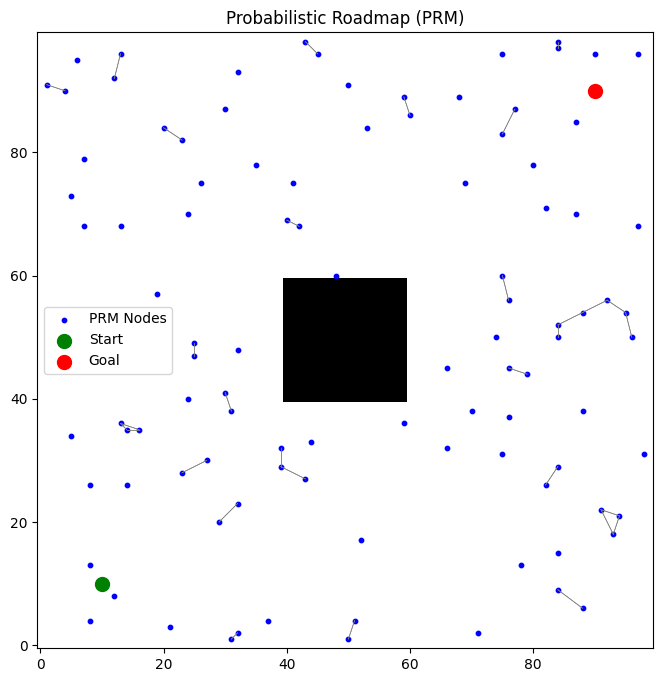

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from queue import Queue

# === Environment Setup ===
grid_size = (100, 100)  # Grid size (100x100)
start = (10, 10)  # Start position (row, col)
goal = (90, 90)  # Goal position (row, col)

# Create a grid with obstacles (1: obstacle, 0: free space)
grid = np.zeros(grid_size)
grid[40:60, 40:60] = 1  # Obstacle in the middle

# === PRM Parameters ===
num_samples = 100  # Number of random samples
radius = 5  # Connection radius for creating edges between nodes

# Sample random configurations in the free space
def sample_free_space(grid, num_samples):
    free_space = []
    rows, cols = grid.shape
    for _ in range(num_samples):
        while True:
            x, y = random.randint(0, rows - 1), random.randint(0, cols - 1)
            if grid[x, y] == 0:  # If the cell is free
                free_space.append((x, y))
                break
    return free_space

# Check if two nodes are connected (no obstacles between them)
def is_connected(p1, p2, grid):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    steps = max(dx, dy)

    for step in range(steps + 1):
        x = int(x1 + (x2 - x1) * step / steps)
        y = int(y1 + (y2 - y1) * step / steps)
        if grid[x, y] == 1:  # Obstacle detected
            return False
    return True

# Construct the PRM roadmap
def prm(grid, num_samples, radius):
    nodes = sample_free_space(grid, num_samples)
    roadmap = {node: [] for node in nodes}

    for node in nodes:
        for neighbor in nodes:
            if node != neighbor and is_connected(node, neighbor, grid):
                dist = np.linalg.norm(np.array(node) - np.array(neighbor))
                if dist <= radius:
                    roadmap[node].append(neighbor)

    return roadmap

# === Visualization of PRM ===
def plot_prm(grid, roadmap):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grid, cmap='gray_r', origin='lower')

    # Plot all nodes
    nodes_x, nodes_y = zip(*list(roadmap.keys()))
    ax.scatter(nodes_y, nodes_x, color='blue', label='PRM Nodes', s=10)

    # Plot edges
    for node, neighbors in roadmap.items():
        for neighbor in neighbors:
            ax.plot([node[1], neighbor[1]], [node[0], neighbor[0]], color='gray', lw=0.5)

    ax.scatter(start[1], start[0], color='green', s=100, label='Start')
    ax.scatter(goal[1], goal[0], color='red', s=100, label='Goal')
    ax.legend()
    plt.title("Probabilistic Roadmap (PRM)")
    plt.show()

# === Run PRM and Visualize ===
roadmap = prm(grid, num_samples, radius)
plot_prm(grid, roadmap)


## RRT

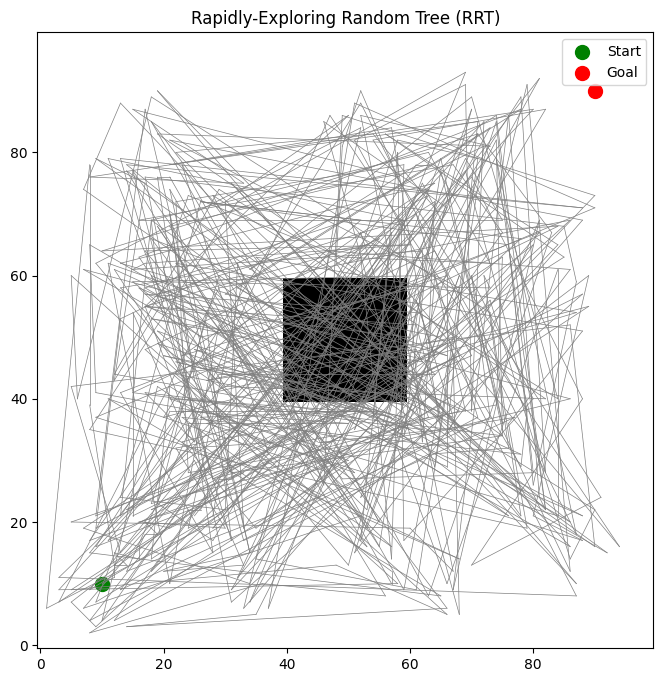

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# === Environment Setup ===
grid_size = (100, 100)  # Grid size (100x100)
start = (10, 10)  # Start position (row, col)
goal = (90, 90)  # Goal position (row, col)

# Create a grid with obstacles (1: obstacle, 0: free space)
grid = np.zeros(grid_size)
grid[40:60, 40:60] = 1  # Obstacle in the middle

# === RRT Parameters ===
step_size = 2  # Step size for tree expansion
max_iterations = 500  # Maximum iterations to run the algorithm
goal_threshold = 5  # Threshold to consider the goal reached

# Randomly sample a point in the free space
def sample_free_space(grid):
    rows, cols = grid.shape
    while True:
        x, y = random.randint(0, rows - 1), random.randint(0, cols - 1)
        if grid[x, y] == 0:  # If the cell is free
            return (x, y)

# Find nearest node in the tree
def nearest_node(tree, node):
    nearest = tree[0]
    min_dist = np.linalg.norm(np.array(node) - np.array(nearest))

    for n in tree:
        dist = np.linalg.norm(np.array(node) - np.array(n))
        if dist < min_dist:
            nearest = n
            min_dist = dist

    return nearest

# Check if two nodes are connected (no obstacles between them)
def is_connected(p1, p2, grid):
    x1, y1 = p1
    x2, y2 = p2
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Prevent division by zero if nodes are identical
    steps = max(dx, dy)
    if steps == 0:
        return True  # If the nodes are the same, they're trivially connected

    for step in range(steps + 1):
        x = int(x1 + (x2 - x1) * step / steps)
        y = int(y1 + (y2 - y1) * step / steps)
        if grid[x, y] == 1:  # Obstacle detected
            return False
    return True

# Expand tree towards a random node
def rrt(grid, start, goal, step_size, max_iterations, goal_threshold):
    tree = [start]  # Initialize the tree with the start node
    for _ in range(max_iterations):
        # Sample random node
        rand_node = sample_free_space(grid)

        # Find nearest node in the tree
        nearest = nearest_node(tree, rand_node)

        # Move from nearest node towards random node
        direction = np.array(rand_node) - np.array(nearest)
        norm = np.linalg.norm(direction)
        if norm > step_size:
            direction = direction / norm * step_size
        new_node = tuple(np.round(np.array(nearest) + direction).astype(int))

        # Check if the new node is connected and valid
        if is_connected(nearest, new_node, grid):
            tree.append(new_node)  # Add new node to the tree

        # Check if the goal is reached
        if np.linalg.norm(np.array(new_node) - np.array(goal)) < goal_threshold:
            tree.append(goal)
            return tree  # Return the tree if goal is reached

    return tree  # Return the tree even if the goal isn't reached

# === Visualization of RRT ===
def plot_rrt(grid, tree, goal):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(grid, cmap='gray_r', origin='lower')

    # Plot the tree
    for i in range(1, len(tree)):
        ax.plot([tree[i-1][1], tree[i][1]], [tree[i-1][0], tree[i][0]], color='gray', lw=0.5)

    # Mark the start and goal
    ax.scatter(start[1], start[0], color='green', s=100, label='Start')
    ax.scatter(goal[1], goal[0], color='red', s=100, label='Goal')
    ax.legend()
    plt.title("Rapidly-Exploring Random Tree (RRT)")
    plt.show()

# === Run RRT and Visualize ===
tree = rrt(grid, start, goal, step_size, max_iterations, goal_threshold)
plot_rrt(grid, tree, goal)
